In [ ]:
# Importing required libraries
import os  # For file path operations
import time  # For timing purposes (unused here)
import gc  # For garbage collection (unused here)
import numpy as np  # For numerical operations
from itertools import product  # For Cartesian product operations (unused here)
from collections import Counter  # For counting label occurrences
from tqdm import tqdm  # For progress bars
import torch  # For tensor operations
import faiss  # For efficient similarity searches
import warnings  # To suppress unnecessary warnings
import matplotlib.pyplot as plt  # For graph visualization
import networkx as nx  # For creating and visualizing graphs
from sklearn.metrics.pairwise import cosine_similarity  # To compute similarity between embeddings

# Suppress warnings to keep output clean
warnings.filterwarnings('ignore')

In [2]:
def load_embedddings_for_e2e(model_name, city, mode="text"):
    assert mode in ["text", "image", "multimodal"]
    
    # Define directory mapping for models
    model_dirs = {
        "CE": "/workspace/persistent/HTClipper/models/pickled/embeddings/grouped-and-masked/trained_declutr_vit/CE",
        "CE+SupCon": "/workspace/persistent/HTClipper/models/pickled/embeddings/grouped-and-masked/trained_declutr_vit/CE+SupCon",
    }
    
    # Check if model_name is valid
    if model_name not in model_dirs:
        raise ValueError(f"Model '{model_name}' not implemented")
        
    emb_dir = model_dirs[model_name]
    
    if model_name == "CE+SupCon":
        filenames = {
            "train_emb": f"{city}_{mode}data_train.pt",
            "train_labels": f"{city}_labels_{mode}_train.pt",
            "test_emb": f"{city}_{mode}data_test.pt",
            "test_labels": f"{city}_labels_{mode}_test.pt",
        }
    else:
        filenames = {
            "train_emb": f"{city}_{mode}data_train.pt",
            "train_labels": f"{city}_labels_train.pt",
            "test_emb": f"{city}_{mode}data_test.pt",
            "test_labels": f"{city}_labels_test.pt",
        }
    
    # Load embeddings and labels
    train_emb = torch.load(os.path.join(emb_dir, filenames["train_emb"]), map_location=torch.device('cpu'))
    train_labels = torch.load(os.path.join(emb_dir, filenames["train_labels"]), map_location=torch.device('cpu'))
    test_emb = torch.load(os.path.join(emb_dir, filenames["test_emb"]), map_location=torch.device('cpu'))
    test_labels = torch.load(os.path.join(emb_dir, filenames["test_labels"]), map_location=torch.device('cpu'))
    
    return train_emb, train_labels, test_emb, test_labels

In [ ]:
# Load embeddings and labels for multimodal mode
train_emb, train_labels, test_emb, test_labels = load_embedddings_for_e2e("CE+SupCon", "south", mode="text")

# Combine training and testing embeddings and labels
data_embeddings = torch.cat((train_emb, test_emb), 0)
data_labels = torch.cat((train_labels, test_labels), 0)

# Count the frequency of each label and create a dictionary
freq_dict = dict(Counter(data_labels.cpu().detach().numpy().tolist()).most_common())

# Select two vendors based on specific frequency thresholds
vendor1 = list({k: v for k, v in freq_dict.items() if 50 < v < 100}.keys())[0]
vendor2 = list({k: v for k, v in freq_dict.items() if 40 < v < 50}.keys())[0]

# Extract indices of advertisements belonging to the selected vendors
label_list = data_labels.cpu().detach().numpy().tolist()
label1_indices = [i for i, label in enumerate(label_list) if label == vendor1]
label2_indices = [i for i, label in enumerate(label_list) if label == vendor2]

# Extract embeddings for the selected vendors
ads1_embeddings = data_embeddings[label1_indices]
ads2_embeddings = data_embeddings[label2_indices]

# Remove duplicate embeddings for vendor2
ads2_embeddings = torch.unique(ads2_embeddings, dim=0)
label2_indices = label2_indices[:ads2_embeddings.shape[0]]

In [ ]:
def plot_knowledge_graph_with_center(embeddings, node_ids, vendor_id):
    """
    Generate and plot a knowledge graph with a central node and cosine similarity-based edges.

    Parameters:
    - embeddings (torch.Tensor): Embeddings to visualize.
    - node_ids (list): Node identifiers.
    - vendor_id (str): Vendor identifier for the title.
    """
    # Compute cosine similarity between embeddings
    embeddings_np = embeddings.numpy()
    cosine_sim_matrix = cosine_similarity(embeddings_np)

    # Create a graph and add nodes
    G = nx.Graph()
    for node_id in node_ids:
        G.add_node(node_id)

    # Add edges based on similarity threshold
    num_nodes = len(node_ids)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            similarity = cosine_sim_matrix[i, j]
            if similarity > 0.5:
                G.add_edge(node_ids[i], node_ids[j], weight=similarity)

    # Identify the central node (first node)
    center_node = node_ids[0]

    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 5))
    node_colors = ['red' if node == center_node else 'skyblue' for node in node_ids]
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, edgecolors='black', linewidths=2)
    edges = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]
    nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights], edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in node_ids}, font_size=10)
    plt.title(f"Retrieving Ads for Vendor: {vendor_id}")
    plt.axis("off")
    plt.show()

def plot_knowledge_graph_with_center_and_top_k(embeddings, node_ids, vendor_id, k=10):
    """
    Generate and plot a knowledge graph for the top-k similar nodes with a central node.

    Parameters:
    - embeddings (torch.Tensor): Embeddings to visualize.
    - node_ids (list): Node identifiers.
    - vendor_id (str): Vendor identifier for the title.
    - k (int): Number of top similar nodes to include.
    """
    # Compute cosine similarity and find top-k indices
    embeddings_np = embeddings.numpy()
    cosine_sim_matrix = cosine_similarity(embeddings_np)
    center_node_index = 0
    similarity_scores = cosine_sim_matrix[center_node_index]
    top_k_indices = similarity_scores.argsort()[::-1][1:k + 1]
    filtered_node_ids = [node_ids[i] for i in [center_node_index] + list(top_k_indices)]

    # Create a graph and add nodes/edges
    G = nx.Graph()
    for node_id in filtered_node_ids:
        G.add_node(node_id)
    for idx in top_k_indices:
        similarity = cosine_sim_matrix[center_node_index, idx]
        G.add_edge(node_ids[center_node_index], node_ids[idx], weight=similarity)

    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6, 5))
    node_colors = ['red' if node == node_ids[center_node_index] else 'skyblue' for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, edgecolors='black', linewidths=2)
    edges = G.edges(data=True)
    weights = [d['weight'] for (_, _, d) in edges]
    if edges:
        nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights], edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(G, pos, labels={node: str(node) for node in G.nodes}, font_size=10)
    plt.title(f"Top {k} Ads for Vendor: {vendor_id}")
    plt.axis("off")
    plt.show()

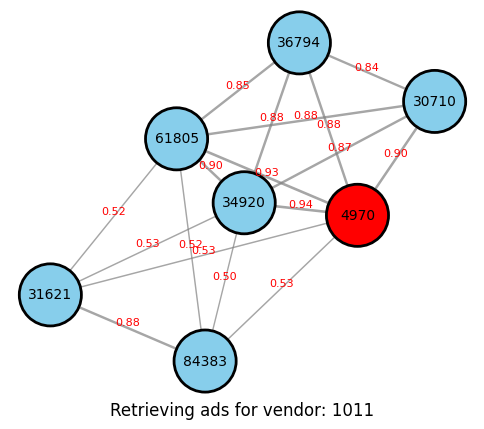

In [ ]:
# Plot knowledge graphs for vendor2
plot_knowledge_graph_with_center(ads2_embeddings, label2_indices, vendor2)
plot_knowledge_graph_with_center_and_top_k(ads2_embeddings, label2_indices, vendor2, k=5)


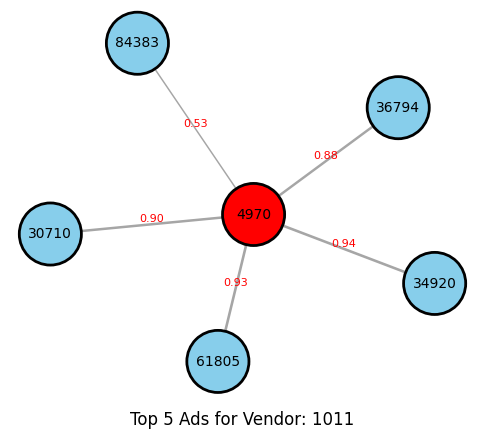

In [ ]:
plot_knowledge_graph_with_center_and_top_k(ads2, label2, vendor2, k=5)